The purpose is to try predict the future bike shares in London (Attribute named "cnt") based on sequential shares and other numerical attributes like temperature, humidity and windspeed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Import the dataset from github link, parse date-time column as pandas date format and treat it as index
Check the first 4 rows
Check presence of null values

In [2]:
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/LSTM/london_bikesharing_kaggle.csv"
dataset = pd.read_csv(url, error_bad_lines=False, header=0, parse_dates=["timestamp"], index_col="timestamp")
dataset.head(4)
dataset.isnull().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

Create additional features using pandas.DatetimeIndex.<> functions.
These features in turn would make the predicted RMSE lower than the standard deviation on test bike shares
We can further create minute of the day to test

In [3]:
dataset['hour'] = dataset.index.hour
dataset['month_day'] = dataset.index.day
dataset['week_day'] = dataset.index.dayofweek
dataset['month'] = dataset.index.month
dataset.head(4)
dataset.isnull().sum()

cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
hour            0
month_day       0
week_day        0
month           0
dtype: int64

Push 90% rows into training data and remaining 10% in test data
Use iloc method to index

In [4]:
size = int(dataset.shape[0] * 0.90)
train = dataset.iloc[0:size, :]
test = dataset.iloc[size:, :]
train.shape, test.shape

((15672, 13), (1742, 13))

Import scaler modules.
Expermientally MinMax and Standard could not bring RMSE down, hence used Robust method

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

In [6]:
# sc = StandardScaler()
# mx = MinMaxScaler()

sc = RobustScaler()
mx = RobustScaler()

 - a = Select numerical features using column index
 - b = put the count of shares which needs to be predicted
 - c = Select remaining features using column index
 - X_train = concat independent attributes horizontally, and then use fit transform scaler method
 - y_train = do the same as X_train only on count of shares

This process would repeat for test datasets also

In [7]:
a = train.iloc[:, 1:5]
b = train.iloc[:, 0]
c = train.iloc[:, 6:13]
X_train = sc.fit_transform(pd.concat((a,c), axis=1))
y_train = mx.fit_transform(pd.DataFrame(b))

In [8]:
a = test.iloc[:, 1:5]
b = test.iloc[:, 0]
c = test.iloc[:, 6:13]
X_test = sc.fit_transform(pd.concat((a,c), axis=1))
y_test = mx.fit_transform(pd.DataFrame(b))

 - Function to create sequence of inputs specific to LSTM network
 - At each iteration X will have first n number of rows (as per n_steps), y data will have the nth data point as dependent attribute

In [9]:
def lstm_inputs(X_data, y_data, n_steps):
    X, y = [], []
    X_data = pd.DataFrame(X_data)
    y_data = pd.DataFrame(y_data)
    for i in range(len(X_data) - n_steps):
        X_rows = X_data.iloc[i:(i + n_steps)].values
        X.append(X_rows)
        y.append(y_data.iloc[i + n_steps])
    return np.array(X), np.array(y)

Call the function created above first on training inputs and output, then on testing input and output. The order does not matter though

In [10]:
X_train, y_train = lstm_inputs(X_train, y_train, 10)
X_test, y_test = lstm_inputs(X_test, y_test, 10)

print(X_train.shape, y_train.shape, X_test.shape, X_test.shape)

(15662, 10, 11) (15662, 1) (1732, 10, 11) (1732, 10, 11)


Import keras and keras modules from keras.layers required for LSTM network

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional

Using TensorFlow backend.


 - Initialize the sequence of network architecture
 - Add a bidirectional layer which further would contain LSTM layer with 64 neurons
 - Return sequences have to be true as we would add another bidirectional or lstm layers. Input shape consits of number of steps and number of independent features
 - Add a dropout layer so that 20% of neurons are not activated during back propagation
 - Redo the layering with varying neurons in the second layer
 - Add Dense output layer with 1 unit as we need only 1 predicted value for every datapoint
 - Finally compile the architecture with optimizer and loss function

In [12]:
lstm = keras.Sequential()

lstm.add(Bidirectional(LSTM(units=64, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))

lstm.add(Dropout(0.20))

lstm.add(Bidirectional(LSTM(units=128, activation="tanh", input_shape=(X_train.shape[1], X_train.shape[2]))))

lstm.add(Dropout(0.20))

lstm.add(Dense(units=1))

lstm.compile(optimizer="adam", loss="mean_squared_error")

 - Fit the model architecture on X train and y train datasets with required epochs and batch size
 - Shuffle would always be False as this series is an ordered time series with respect to date and time
 - Validation split is required to check validation loss

In [13]:
history = lstm.fit(X_train, y_train, epochs=20, batch_size=32, shuffle=False, validation_split=0.10)

Train on 14095 samples, validate on 1567 samples
Epoch 1/20
14095/14095 [==============================] - 13s 900us/step - loss: 0.2046 - val_loss: 0.1751
Epoch 2/20
14095/14095 [==============================] - 12s 848us/step - loss: 0.0940 - val_loss: 0.1011
Epoch 3/20
14095/14095 [==============================] - 12s 862us/step - loss: 0.0672 - val_loss: 0.0950
Epoch 4/20
14095/14095 [==============================] - 12s 883us/step - loss: 0.0638 - val_loss: 0.1115
Epoch 5/20
14095/14095 [==============================] - 12s 884us/step - loss: 0.0576 - val_loss: 0.1077
Epoch 6/20
14095/14095 [==============================] - 12s 885us/step - loss: 0.0567 - val_loss: 0.1180
Epoch 7/20
14095/14095 [==============================] - 13s 893us/step - loss: 0.0541 - val_loss: 0.1102
Epoch 8/20
14095/14095 [==============================] - 13s 892us/step - loss: 0.0512 - val_loss: 0.1072
Epoch 9/20
14095/14095 [==============================] - 13s 904us/step - loss: 0.0529 - val_l

Plot the training loss and validation loss with respect to each epoch

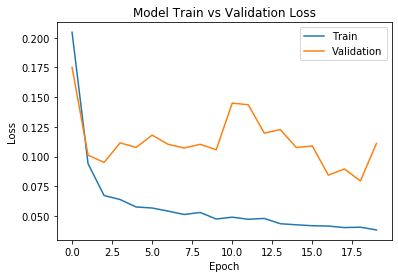

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

Use predict method to get predicted y

In [15]:
y_pred = lstm.predict(X_test)

Reverse transform from Scaler method used above to get original values

In [16]:
y_train_inv = mx.inverse_transform(y_train.reshape(1, -1))
y_test_inv = mx.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = mx.inverse_transform(y_pred)

Import rmse module to check rmse on test & predicted data

In [17]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten(), squared=False)

498.57879281103016

Check the standard deviation of testing data. __Generally if RMSE is less than the sd, then we are predicting better than average__

In [18]:
y_pred_inv.flatten().std()

698.47797

__Plot the predicted and actual bike shares__

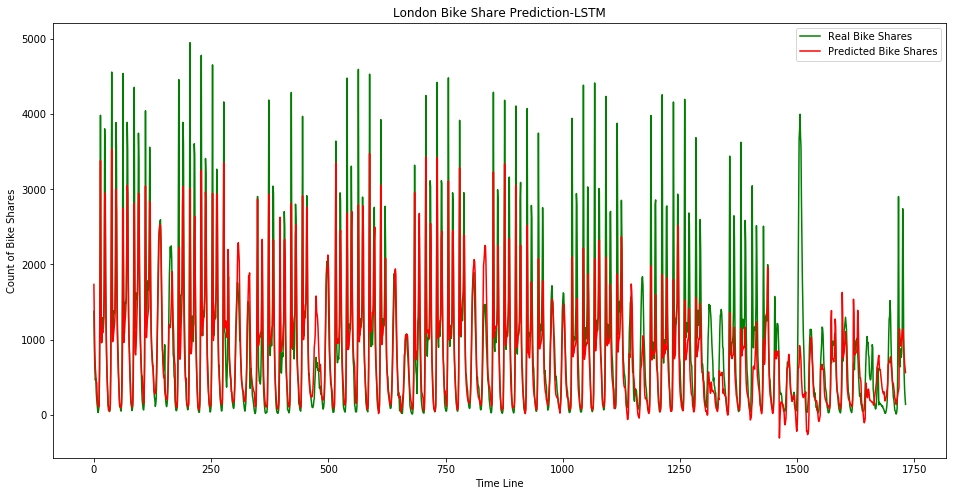

In [19]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inv.flatten(), color = 'green', label = 'Real Bike Shares')
plt.plot(y_pred_inv.flatten(), color = 'red', label = 'Predicted Bike Shares')
plt.title('London Bike Share Prediction-LSTM')
plt.xlabel('Time Line')
plt.ylabel('Count of Bike Shares')
plt.legend(loc='best')
plt.show()

__Things to try out more for reducing rmse__
- We can increase/decrease the number of steps from 10
- We can try removing Bidirectional layer and use plain vanilla LSTM network or stacked LSTM network
- We can tune hyper-parameters like number of drop out rate, bat size, epochs, optimizer function or loss function using GridSearchCV()
- We can try adding callbacks like EaryStopping and ModelSelect
- We can try changing the validation split % from 10%

__Special thanks to Venelin Valkov for guiding through this exercise and Jason Brownlee for teaching materials__